# Model Training
Train GAN models for HK and US stock market, repectively

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM, Conv1D, LeakyReLU, Flatten
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.metrics import Accuracy, MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
from keras.callbacks import ModelCheckpoint, EarlyStopping


### Common variables and functions

In [11]:
MODEL_STRUCTURE_PATH = "./diagrams/model_structures"
MODEL_TRAIN_HISTORY_DIAGRAMS_PATH = "./diagrams/model/training"
# PROCESSED_STOCKS_PATH = "./data/processed"
TRAINING_STOCKS_PATH = "./data/processed/training_data"
EVALUATE_STOCKS_PATH = "./data/processed/stocks_for_evaluate"
TRAIN_STOCK_NAMES_PATH = "./data/processed/stock_names_for_training"

# stocks model checkpoint paths
HK_MODELS_CHECKPOINT_PATH = "./model/hk"
US_MODELS_CHECKPOINT_PATH = "./model/us"

hk_gan_file_path = "{}/gan.h5".format(HK_MODELS_CHECKPOINT_PATH)
hk_gan_train_history_file_path = "{}/gan_history/gan_training_history.npy".format(HK_MODELS_CHECKPOINT_PATH)

us_gan_file_path = "{}/gan.h5".format(US_MODELS_CHECKPOINT_PATH)
us_gan_train_history_file_path = "{}/gan_history/gan_training_history.npy".format(US_MODELS_CHECKPOINT_PATH)

TRAIN_EPOCHS = 100
time_lag = 30 # days (aka time steps/step size)

def create_dir_if_not_exist(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname, exist_ok=True)

### Import datasets

In [10]:
# stock names
template_filename_train_x = "{}/{}_train_X.npy"
template_filename_train_y = "{}/{}_train_y.npy"

template_filename_test_x = "{}/{}_test_X.npy"
template_filename_test_y = "{}/{}_test_y.npy"

fns_hk = np.load("{}/hk_train_stock_names.npy".format(TRAIN_STOCK_NAMES_PATH))
fns_us = np.load("{}/us_train_stock_names.npy".format(TRAIN_STOCK_NAMES_PATH))

X_train_hk = {}
y_train_hk = {}
X_test_hk = {}
y_test_hk = {}
for i in range(len(fns_hk)):
    X_train_hk[fns_hk[i]] = np.load(template_filename_train_x.format(
        TRAINING_STOCKS_PATH,
        fns_hk[i]
    ))

    y_train_hk[fns_hk[i]] = np.load(template_filename_train_y.format(
        TRAINING_STOCKS_PATH,
        fns_hk[i]
    ))

    X_test_hk[fns_hk[i]] = np.load(template_filename_test_x.format(
        TRAINING_STOCKS_PATH,
        fns_hk[i]
    ))

    y_test_hk[fns_hk[i]] = np.load(template_filename_test_y.format(
        TRAINING_STOCKS_PATH,
        fns_hk[i]
    ))

X_train_us = {}
y_train_us = {}
X_test_us = {}
y_test_us = {}
for i in range(len(fns_us)):
    X_train_us[fns_us[i]] = np.load(template_filename_train_x.format(
        TRAINING_STOCKS_PATH,
        fns_us[i]
    ))

    y_train_us[fns_us[i]] = np.load(template_filename_train_y.format(
        TRAINING_STOCKS_PATH,
        fns_us[i]
    ))

    X_test_us[fns_us[i]] = np.load(template_filename_test_x.format(
        TRAINING_STOCKS_PATH,
        fns_us[i]
    ))

    y_test_us[fns_us[i]] = np.load(template_filename_test_y.format(
        TRAINING_STOCKS_PATH,
        fns_us[i]
    ))

# Check the imports, minus the one stock that used to test generalizability
assert len(X_train_hk) == 49
assert len(y_train_hk) == 49
assert len(X_test_hk) == 49
assert len(X_test_hk) == 49

assert len(X_train_us) == 49
assert len(y_train_us) == 49
assert len(X_test_us) == 49
assert len(X_test_us) == 49



### Define models structure
##### GAN models
###### Reference:
```
Salimath, S., Chatterjee, T., Mathai, T., Kamble, P., & Kolhekar, M. (2021, April). Prediction of Stock Price for Indian Stock Market: A Comparative Study Using LSTM and GRU. In International Conference on Advances in Computing and Data Sciences (pp. 292-302). Springer, Cham.
Lin, H., Chen, C., Huang, G., & Jafari, A. (2021). Stock price prediction using Generative Adversarial Networks. Journal of Computer Science, (17(3), 188–196. doi:10.3844/jcssp.2021.188.196
https://github.com/grudloff/stock_market_GAN
https://github.com/yiweizhang526/time-series-prediction-with-gan
Train with multiple stocks: https://www.kaggle.com/humamfauzi/multiple-stock-prediction-using-single-nn
```

###### GAN - Generator

In [6]:
def make_generator(input_dim, feature_cnt) -> tf.keras.models.Model:
    model = Sequential()

    # Input layer
    model.add(
        Input(
            shape=(input_dim, feature_cnt)
        )
    )

    # First layer LSTM + dropout layer
    model.add(
        LSTM(
            units=128,
            return_sequences=True,
            activation="tanh",
            input_shape=(input_dim, feature_cnt)
        )
    )
    model.add(
        Dropout(rate=0.3)
    )

    # Second layer LSTM + dropout layer
    model.add(
        LSTM(
            units=128,
            return_sequences=False,
            activation="tanh",
            input_shape=(input_dim, feature_cnt)
        )
    )
    model.add(
        Dropout(rate=0.5)
    )

    # Output dense layer with relu
    model.add(
        Dense(
            units=1,
            activation="relu",
        )
    )

    # compile model and use Adam optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=None,
        metrics=[
            MeanSquaredError(),
            MeanAbsoluteError(),
            RootMeanSquaredError(),
            MeanAbsolutePercentageError()
        ]
    )

    print(model.summary())
    return model


###### GAN - Discriminator

In [20]:
def make_discriminator() -> tf.keras.models.Model:
    model = Sequential()

    model.add(
        Input(
            shape=(time_lag + 1, 1) # https://github.com/yiweizhang526/time-series-prediction-with-gan/blob/d09e5eecca8e85beeea88bf331d35cfc7614a223/keras_code/keras_GAN.py#L82
        )
    )

    # 1st cnn
    model.add(
        Conv1D(32, input_shape=(time_lag + 1, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01))
    )

    # 2nd cnn + bn
    model.add(
        Conv1D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(alpha=0.01))
    )
    model.add(
        BatchNormalization()
    )

    # 3rd cnn + bn
    model.add(
        Conv1D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(alpha=0.01))
    )
    model.add(
        BatchNormalization()
    )

    # model.add(
    #     Flatten()
    # )

    model.add(
        Dense(128, activation=LeakyReLU(), use_bias=False)
    )

    model.add(
        Dense(2, activation="sigmoid")
    )

    print(model.summary())

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           70656     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 202,369
Trainable params: 202,369
Non-trainable params: 0
_________________________________________________________________
None


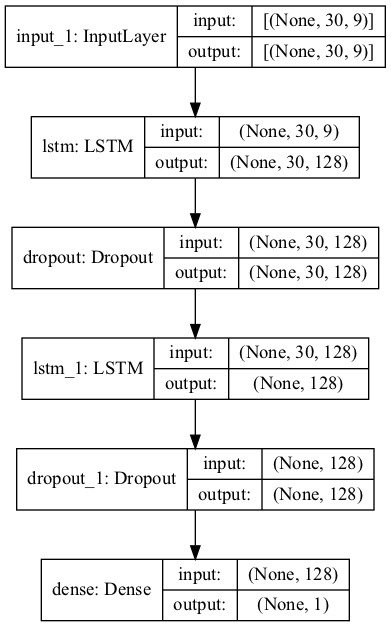

In [7]:
# plot model structure (Generator)
create_dir_if_not_exist(MODEL_STRUCTURE_PATH)
plot_model(
    make_generator(input_dim=X_train_hk[fns_hk[0]].shape[1],
                    feature_cnt=X_train_hk[fns_hk[0]].shape[2]
                    ),
    show_shapes=True,
    show_layer_names=True,
    to_file="{}/GAN_generator_structure.png".format(MODEL_STRUCTURE_PATH)
)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 16, 32)            128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 8, 64)             10304     
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 64)             256       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 4, 128)            41088     
_________________________________________________________________
batch_normalization_9 (Batch (None, 4, 128)            512       
_________________________________________________________________
dense_9 (Dense)              (None, 4, 128)            16384     
_________________________________________________________________
dense_10 (Dense)             (None, 4, 2)             

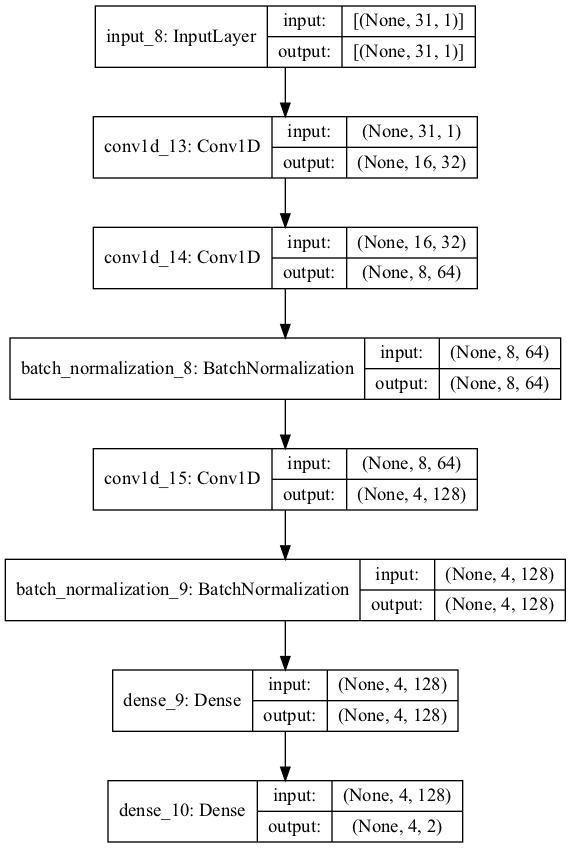

In [22]:
# plot model structure (Discriminator)
create_dir_if_not_exist(MODEL_STRUCTURE_PATH)
plot_model(
    make_discriminator(),
    show_shapes=True,
    show_layer_names=True,
    to_file="{}/GAN_generator_structure.png".format(MODEL_STRUCTURE_PATH)
)

### Model training

In [ ]:
def train_step_def(real_x, real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)

        data_true = tf.concat([])


In [24]:
X_train_hk[fns_hk[0]][0].shape

(30, 9)

In [26]:
tf.concat([X_train_hk[fns_hk[0]][0], y_train_hk[fns_hk[0]][0]], axis=1)

InvalidArgumentError: ConcatOp : Ranks of all input tensors should match: shape[0] = [30,9] vs. shape[1] = [1] [Op:ConcatV2] name: concat

##### Train BGRU model for Hong Kong Stocks

In [7]:
# define HK model's generator and discriminator
generator = make_generator(
    input_dim=X_train_hk[fns_hk[0]].shape[1],
    feature_cnt=X_train_hk[fns_hk[0]].shape[2]
)

discriminator = make_discriminator()

##### Train BGRU model for United States stocks

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16, 32)            128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 8, 64)             10304     
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 64)             256       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 4, 128)            41088     
_________________________________________________________________
batch_normalization_7 (Batch (None, 4, 128)            512       
_________________________________________________________________
dense_7 (Dense)              (None, 4, 128)            16384     
_________________________________________________________________
dense_8 (Dense)              (None, 4, 2)             